In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table

# Assign the station class to a variable called `Station`
Station = Base.classes.station

# Assign the measurement class to a variable called `Measurement`
Measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [9]:
# Use the inspector to print the column names and its types
from sqlalchemy import  inspect

# Create the inspector and connect it to the engine
inspector = inspect(engine)

# Collect the names of tables within the database
table_list = inspector.get_table_names()

for table in table_list:
    print(f"========== Columns in table {table} ===============")
    columns = inspector.get_columns(table)
    for column in columns:
         print(column["name"], column["type"])

========== Columns in table measurement ===============
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
========== Columns in table station ===============
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
query_result_recent_date = session.query(Measurement.date). \
                                order_by(Measurement.date.desc()).limit(1) 

# Extract the content of SQLAlchemy row object 
for row in query_result_recent_date:
    
    # Convert date str to date format
    recent_date = dt.datetime.strptime(row[0], '%Y-%m-%d')
    
    print(f"recent date: {recent_date}")    

recent date: 2017-08-23 00:00:00


In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
date_last_12_months = dt.datetime( recent_date.year -1 \
                                 , recent_date.month \
                                 , recent_date.day)
print (f"date_last_12_months: {date_last_12_months}")

# Extract the yyyy-mm-dd from the date time and save as string
date_prev_year = dt.datetime.strftime(date_last_12_months, '%Y-%m-%d')
print (f"date_prev_year     : {date_prev_year}")

# Perform a query to retrieve the date and precipitation scores
# Use the date in str format saved in date_prev_year
sel          = [Measurement.date, Measurement.prcp]
query_result = session.query(*sel).filter(Measurement.date >= date_prev_year).all()

# Save the query results as a Pandas DataFrame 
precipitation_data = pd.DataFrame(query_result, columns=["Date", "Precipitation"])

# Replace NAN with 0
precipitation_data = precipitation_data.fillna(0)

# Sort the dataframe by date
precipitation_data = precipitation_data.sort_values(["Date"], ascending=True)

# Set index to date column - Note: Do not set the index per our instructor
#precipitation_data = precipitation_data.set_index("Date")
precipitation_data

date_last_12_months: 2016-08-23 00:00:00
date_prev_year     : 2016-08-23


,Date,Precipitation
0,2016-08-23,0.00
1009,2016-08-23,0.00
1529,2016-08-23,1.79
704,2016-08-23,0.05
361,2016-08-23,0.15
...,...,...
1527,2017-08-22,0.00
1008,2017-08-23,0.00
360,2017-08-23,0.00
1528,2017-08-23,0.08


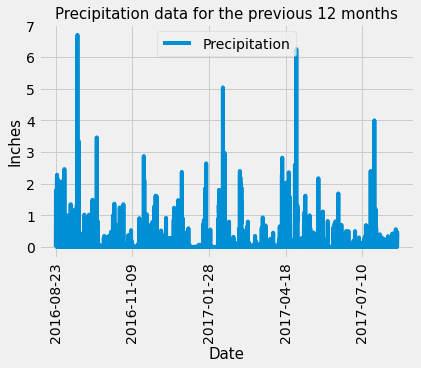

In [12]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_data.plot(x="Date", y="Precipitation", rot=90)

# Set the title, x and y label
plt.title("Precipitation data for the previous 12 months", fontsize = 15)
plt.xlabel("Date",   fontsize = 15)
plt.ylabel("Inches", fontsize = 15)
plt.legend()
plt.show()

In [13]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_data.describe()

,Precipitation
count,2230.000000
mean,0.160664
std,0.442067
min,0.000000
25%,0.000000
50%,0.010000
75%,0.110000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number stations in the dataset
session.query(Station.id).count()

9

In [15]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
sel     = [Measurement.station, \
           func.count(Measurement.station)]    

active_stations = session.query(*sel).\
                       group_by(Measurement.station).\
                       order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [16]:
# Save the most active station
most_active_station = active_stations [0][0]
most_active_station 

'USC00519281'

In [20]:
# Using the most active station id from the previous query, 
# calculate the lowest, highest, and average temperature.
sel = [ Measurement.station \
      , func.min(Measurement.tobs) \
      , func.max(Measurement.tobs) \
      , func.avg(Measurement.tobs) \
      ]    
aggr_most_active_stations = session.query(*sel).\
                            filter(Measurement.station == most_active_station ).\
                          group_by(Measurement.station).all()
    
aggr_most_active_stations

[('USC00519281', 54.0, 85.0, 71.66378066378067)]

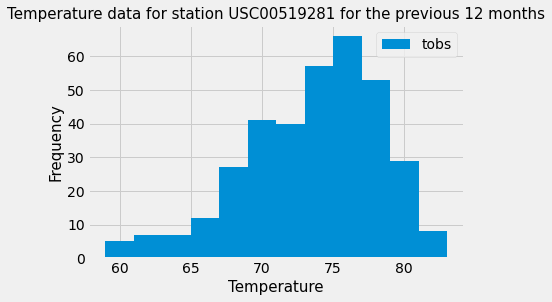

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station 

sel = [Measurement.tobs]    

query_result_active_12_mons = session.query(*sel).\
    filter(Measurement.date    >= date_prev_year).\
    filter(Measurement.station == most_active_station ).all()

# Save the query results as a Pandas DataFrame 
active_12_mons = pd.DataFrame(query_result_active_12_mons, columns=["Temperature"])

# plot the results as a histogram
plt.hist(active_12_mons, bins=12,label='tobs') #rwidth=10, 

# Set the title, x and y label
plt.title(f"Temperature data for station {most_active_station} for the previous 12 months", fontsize = 15)
plt.xlabel("Temperature",   fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)
plt.legend()
plt.show()

# Close session

In [22]:
# Close Session
session.close()